# Discrete Models Task

### 1) Data Preparation

Installing 'tslearn' - only run if not installed previously (if necessary, for more information see documentation of the package at https://tslearn.readthedocs.io/en/latest/index.html?highlight=install

In [1]:
##!pip install tslearn

Importing packages

In [3]:
import datetime
import pandas as pd
from pandas import Series
from pandas import DataFrame
from pandas import concat
import numpy as np
import time, datetime
import matplotlib.pyplot as plt
import sys
from tslearn.generators import random_walks
from tslearn.preprocessing import TimeSeriesScalerMeanVariance
from tslearn.piecewise import PiecewiseAggregateApproximation
from tslearn.piecewise import SymbolicAggregateApproximation, OneD_SymbolicAggregateApproximation
import string
from collections import Counter
from nltk import ngrams
import itertools
import random
from matplotlib.collections import LineCollection
from matplotlib.colors import ListedColormap, BoundaryNorm
from sklearn.metrics import confusion_matrix
import seaborn as sns
from sklearn.datasets import make_classification  
from sklearn.neighbors import KNeighborsClassifier  
from sklearn.ensemble import RandomForestClassifier  
from sklearn.model_selection import train_test_split  
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import fbeta_score
from sklearn.preprocessing import MinMaxScaler

Reading the data, converting the time to timestamp and indexing the date to use it as a time series

In [4]:
#Data Paths
DATA_PATH = sys.path[0]+"\\data\\"
filename_train1="BATADAL_dataset03.csv"
filename_train2="BATADAL_dataset04.csv"
filename_test="BATADAL_test_dataset.csv"

#Reading the data
dftrain1 = pd.read_csv(DATA_PATH + filename_train1)
dftrain2 = pd.read_csv(DATA_PATH + filename_train2)
dftest = pd.read_csv(DATA_PATH + filename_test)

# Modify string date to timestamp
dftrain1.DATETIME = dftrain1.DATETIME.apply(lambda s: pd.to_datetime(s,format='%d/%m/%y %H'))
dftrain2.DATETIME = dftrain2.DATETIME.apply(lambda s: pd.to_datetime(s,format='%d/%m/%y %H'))
dftest.DATETIME = dftest.DATETIME.apply(lambda s: pd.to_datetime(s,format='%d/%m/%y %H'))

# Choosing 0 if not an anomaly and 1 if anomaly
#dftrain2[' ATT_FLAG']=dftrain2[' ATT_FLAG'].apply(lambda x: 0 if x==-999 else x)

# Indexing
dftrain1 = dftrain1.set_index('DATETIME')
dftrain2 = dftrain2.set_index('DATETIME')
dftest = dftest.set_index('DATETIME')

#dftrain1.shift(1)

#### Labeling the attacks on dftrain2 according to the information below

###### For L_T7
13/09/2016 23 - 16/09/2016 00 |
26/09/2016 11 - 27/09/2016 10
###### For F_PU10 and F_PU11
26/09/2016 11 - 27/09/2016 10
###### For L_T1
09/10/2016 9 - 11/10/2016 20 |
29/10/2016 19 - 02/11/2016 16 |
14/12/2016 15 - 19/12/2016 04
###### For F_PU1 and F_PU2
29/10/2016 19 - 02/11/2016 16 |
14/12/2016 15 - 19/12/2016 04
###### For L_T4
26/11/2016 17 - 29/11/2016 04

In [5]:
#L_T7
dftrain2_L_T7=dftrain2.loc[:,[' L_T7',' ATT_FLAG']]
dftrain2_L_T7.loc[:,' ATT_FLAG']=0
dftrain2_L_T7.loc['2016-09-13 23':'2016-09-16 00',' ATT_FLAG']=1
dftrain2_L_T7.loc['2016-09-26 11':'2016-09-27 10',' ATT_FLAG']=1
#F_PU10 and F_PU11
dftrain2_F_PU10=dftrain2.loc[:,[' F_PU10',' ATT_FLAG']]
dftrain2_F_PU10.loc[:,' ATT_FLAG']=0
dftrain2_F_PU10.loc['2016-09-26 11':'2016-09-27 10',' ATT_FLAG']=1

dftrain2_F_PU11=dftrain2.loc[:,[' F_PU11',' ATT_FLAG']]
dftrain2_F_PU11.loc[:,' ATT_FLAG']=0
dftrain2_F_PU11.loc['2016-09-26 11':'2016-09-27 10',' ATT_FLAG']=1
#L_T1
dftrain2_L_T1=dftrain2.loc[:,[' L_T1',' ATT_FLAG']]
dftrain2_L_T1.loc[:,' ATT_FLAG']=0
dftrain2_L_T1.loc['2016-10-09 09':'2016-10-11 20',' ATT_FLAG']=1
dftrain2_L_T1.loc['2016-10-29 19':'2016-11-02 16',' ATT_FLAG']=1
dftrain2_L_T1.loc['2016-12-14 15':'2016-12-19 04',' ATT_FLAG']=1
#F_PU1 and F_PU2
dftrain2_F_PU1=dftrain2.loc[:,[' F_PU1',' ATT_FLAG']]
dftrain2_F_PU1.loc[:,' ATT_FLAG']=0
dftrain2_F_PU1.loc['2016-10-29 19':'2016-11-02 16',' ATT_FLAG']=1
dftrain2_F_PU1.loc['2016-12-14 15':'2016-12-19 04',' ATT_FLAG']=1

dftrain2_F_PU2=dftrain2.loc[:,[' F_PU2',' ATT_FLAG']]
dftrain2_F_PU2.loc[:,' ATT_FLAG']=0
dftrain2_F_PU2.loc['2016-10-29 19':'2016-11-02 16',' ATT_FLAG']=1
dftrain2_F_PU2.loc['2016-12-14 15':'2016-12-19 04',' ATT_FLAG']=1
#L_T4
dftrain2_L_T4=dftrain2.loc[:,[' L_T4',' ATT_FLAG']]
dftrain2_L_T4.loc[:,' ATT_FLAG']=0
dftrain2_L_T4.loc['2016-11-26 17':'2016-11-29 04',' ATT_FLAG']=1

#dftrain2[' ATT_FLAG']=dftrain2[' ATT_FLAG'].apply(lambda x: 0 if x==-999 else x)

#### Labling the attacks on dftest according to the batadal dataset

In [130]:
###Creating one dataset for each dimension
#Attack 1
dftest_L_T3=dftest.loc[:,['L_T3',' ATT_FLAG']]
dftest_P_U4=dftest.loc[:,['F_PU4', ' ATT_FLAG']]
dftest_P_U5=dftest.loc[:,['F_PU5', ' ATT_FLAG']]
#Attack 2
dftest_L_T2=dftest.loc[:,['L_T2', ' ATT_FLAG']]
#Attack 3
dftest_P_U3=dftest.loc[:,['F_PU3', ' ATT_FLAG']]
#Attack 4
dftest_P_U3=dftest.loc[:,['F_PU3', ' ATT_FLAG']]
#Attack 5
dftest_L_T2=dftest.loc[:,['L_T2', ' ATT_FLAG']]
dftest_V2=dftest.loc[:,['F_V2', ' ATT_FLAG']]
dftest_P_J14=dftest.loc[:,['P_J14', ' ATT_FLAG']]
dftest_P_J422=dftest.loc[:,['P_J422', ' ATT_FLAG']]
#Attack 6
dftest_L_T7=dftest.loc[:,['L_T7', ' ATT_FLAG']]
dftest_P_U10=dftest.loc[:,['F_PU10', ' ATT_FLAG']]
dftest_P_U11=dftest.loc[:,['F_PU11', ' ATT_FLAG']]
dftest_P_J14=dftest.loc[:,['P_J14', ' ATT_FLAG']]
dftest_P_J422=dftest.loc[:,['P_J422', ' ATT_FLAG']]
#Attack 7
dftest_L_T4=dftest.loc[:,['L_T4', ' ATT_FLAG']]
dftest_L_T6=dftest.loc[:,['L_T6', ' ATT_FLAG']]

In [131]:
###Adding one for anomalies
#Attack 1
dftest_L_T3.loc['2017-01-16 09':'2017-01-19 06', ' ATT_FLAG']=1
dftest_P_U4.loc['2017-01-16 09':'2017-01-19 06', ' ATT_FLAG']=1
dftest_P_U5.loc['2017-01-16 09':'2017-01-19 06', ' ATT_FLAG']=1
#Attack 2
dftest_L_T2.loc['2017-01-30 08':'2017-02-02 00', ' ATT_FLAG']=1
#Attack 3
dftest_P_U3.loc['2017-02-09 03':'2017-02-10 09', ' ATT_FLAG']=1
#Attack 4
dftest_P_U3.loc['2017-02-12 01':'2017-02-13 07', ' ATT_FLAG']=1
#Attack 5
dftest_L_T2.loc['2017-02-24 05':'2017-02-28 08', ' ATT_FLAG']=1
dftest_V2.loc['2017-02-24 05':'2017-02-28 08', ' ATT_FLAG']=1
dftest_P_J14.loc['2017-02-24 05':'2017-02-28 08', ' ATT_FLAG']=1
dftest_P_J422.loc['2017-02-24 05':'2017-02-28 08', ' ATT_FLAG']=1
#Attack 6
dftest_L_T7.loc['2017-03-10 14':'2017-03-13 21', ' ATT_FLAG']=1
dftest_P_U10.loc['2017-03-10 14':'2017-03-13 21', ' ATT_FLAG']=1
dftest_P_U11.loc['2017-03-10 14':'2017-03-13 21', ' ATT_FLAG']=1
dftest_P_J14.loc['2017-03-10 14':'2017-03-13 21', ' ATT_FLAG']=1
dftest_P_J422.loc['2017-03-10 14':'2017-03-13 21', ' ATT_FLAG']=1
#Attack 7
dftest_L_T4.loc['2017-03-25 20':'2017-03-27 01', ' ATT_FLAG']=1
dftest_L_T6.loc['2017-03-25 20':'2017-03-27 01', ' ATT_FLAG']=1

#### Attack 1

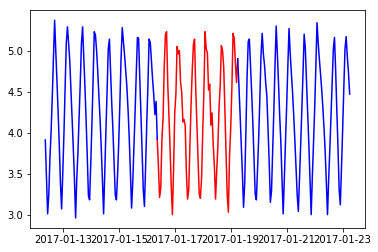

In [166]:
plt.plot(dftest_L_T3.loc['2017-01-16 09':'2017-01-19 06', 'L_T3'],color="red")

plt.plot(dftest_L_T3.loc['2017-01-12 09':'2017-01-16 09', 'L_T3'],color="blue")
plt.plot(dftest_L_T3.loc['2017-01-19 06':'2017-01-23 06', 'L_T3'],color="blue")

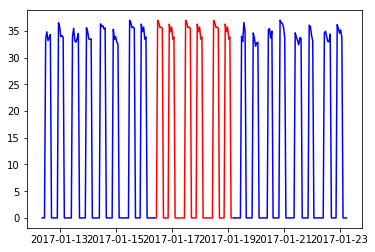

In [167]:
plt.plot(dftest_P_U4.loc['2017-01-16 09':'2017-01-19 06', 'F_PU4'],color="red")

plt.plot(dftest_P_U4.loc['2017-01-12 09':'2017-01-16 09', 'F_PU4'],color="blue")
plt.plot(dftest_P_U4.loc['2017-01-19 06':'2017-01-23 06', 'F_PU4'],color="blue")

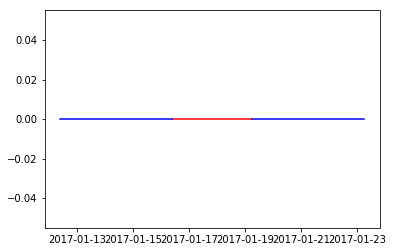

In [168]:
plt.plot(dftest_P_U5.loc['2017-01-16 09':'2017-01-19 06', 'F_PU5'],color="red")

plt.plot(dftest_P_U5.loc['2017-01-12 09':'2017-01-16 09', 'F_PU5'],color="blue")
plt.plot(dftest_P_U5.loc['2017-01-19 06':'2017-01-23 06', 'F_PU5'],color="blue")

#### Attack 2

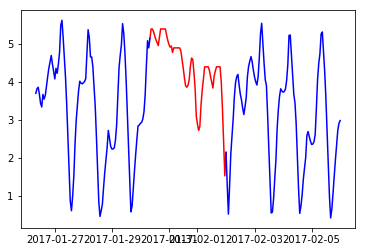

In [171]:
plt.plot(dftest_L_T2.loc['2017-01-30 08':'2017-02-02 00', 'L_T2'],color="red")

plt.plot(dftest_L_T2.loc['2017-01-26 08':'2017-01-30 08', 'L_T2'],color="blue")
plt.plot(dftest_L_T2.loc['2017-02-02 00':'2017-02-06 00', 'L_T2'],color="blue")

#### Attack 3

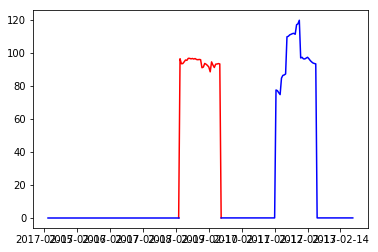

In [186]:
plt.plot(dftest_P_U3.loc['2017-02-09 02':'2017-02-10 09', 'F_PU3'],color="red")

plt.plot(dftest_P_U3.loc['2017-02-05 03':'2017-02-09 02', 'F_PU3'],color="blue")
plt.plot(dftest_P_U3.loc['2017-02-10 09':'2017-02-14 09', 'F_PU3'],color="blue")


#### Attack 4

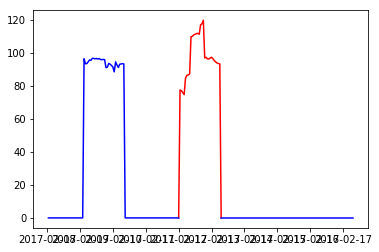

In [185]:
plt.plot(dftest_P_U3.loc['2017-02-12 00':'2017-02-13 07', 'F_PU3'],color="red")

plt.plot(dftest_P_U3.loc['2017-02-08 01':'2017-02-12 00', 'F_PU3'],color="blue")
plt.plot(dftest_P_U3.loc['2017-02-13 07':'2017-02-17 07', 'F_PU3'],color="blue")

#### Attack 5

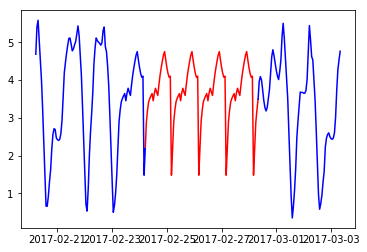

In [187]:
plt.plot(dftest_L_T2.loc['2017-02-24 05':'2017-02-28 08', 'L_T2'],color="red")

plt.plot(dftest_L_T2.loc['2017-02-20 05':'2017-02-24 05', 'L_T2'],color="blue")
plt.plot(dftest_L_T2.loc['2017-02-28 08':'2017-03-03 08', 'L_T2'],color="blue")

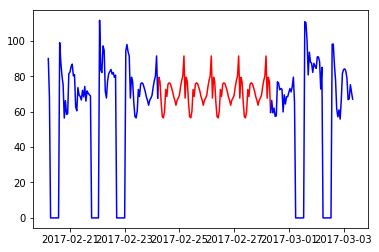

In [191]:
plt.plot(dftest_V2.loc['2017-02-24 05':'2017-02-28 08', 'F_V2'],color="red")

plt.plot(dftest_V2.loc['2017-02-20 05':'2017-02-24 05', 'F_V2'],color="blue")
plt.plot(dftest_V2.loc['2017-02-28 08':'2017-03-03 08', 'F_V2'],color="blue")

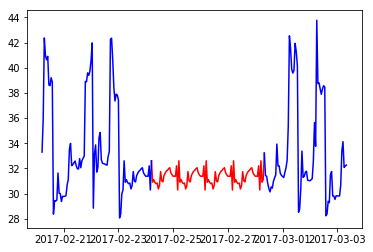

In [192]:
plt.plot(dftest_P_J14.loc['2017-02-24 05':'2017-02-28 08', 'P_J14'],color="red")

plt.plot(dftest_P_J14.loc['2017-02-20 05':'2017-02-24 05', 'P_J14'],color="blue")
plt.plot(dftest_P_J14.loc['2017-02-28 08':'2017-03-03 08', 'P_J14'],color="blue")

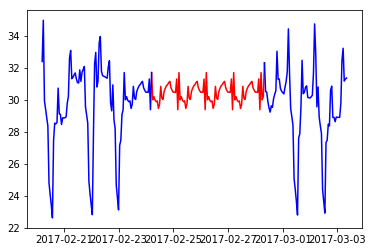

In [194]:
plt.plot(dftest_P_J422.loc['2017-02-24 05':'2017-02-28 08', 'P_J422'],color="red")

plt.plot(dftest_P_J422.loc['2017-02-20 05':'2017-02-24 05', 'P_J422'],color="blue")
plt.plot(dftest_P_J422.loc['2017-02-28 08':'2017-03-03 08', 'P_J422'],color="blue")

##### Attack 6

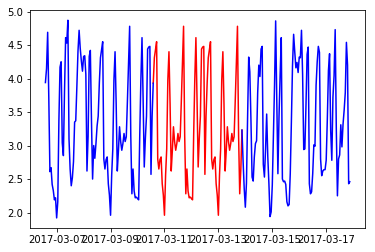

In [195]:
plt.plot(dftest_L_T7.loc['2017-03-10 14':'2017-03-13 21', 'L_T7'],color="red")

plt.plot(dftest_L_T7.loc['2017-03-06 14':'2017-03-10 14', 'L_T7'],color="blue")
plt.plot(dftest_L_T7.loc['2017-03-13 21':'2017-03-17 21', 'L_T7'],color="blue")

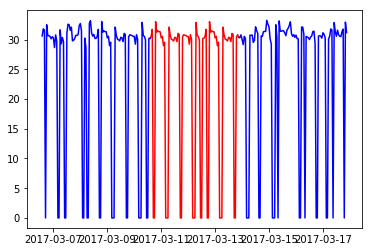

In [196]:
plt.plot(dftest_P_U10.loc['2017-03-10 14':'2017-03-13 21', 'F_PU10'],color="red")

plt.plot(dftest_P_U10.loc['2017-03-06 14':'2017-03-10 14', 'F_PU10'],color="blue")
plt.plot(dftest_P_U10.loc['2017-03-13 21':'2017-03-17 21', 'F_PU10'],color="blue")

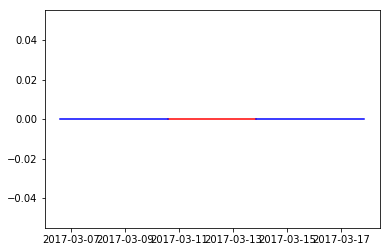

In [197]:
plt.plot(dftest_P_U11.loc['2017-03-10 14':'2017-03-13 21', 'F_PU11'],color="red")

plt.plot(dftest_P_U11.loc['2017-03-06 14':'2017-03-10 14', 'F_PU11'],color="blue")
plt.plot(dftest_P_U11.loc['2017-03-13 21':'2017-03-17 21', 'F_PU11'],color="blue")

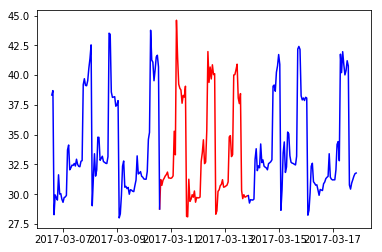

In [198]:
plt.plot(dftest_P_J14.loc['2017-03-10 14':'2017-03-13 21', 'P_J14'],color="red")

plt.plot(dftest_P_J14.loc['2017-03-06 14':'2017-03-10 14', 'P_J14'],color="blue")
plt.plot(dftest_P_J14.loc['2017-03-13 21':'2017-03-17 21', 'P_J14'],color="blue")

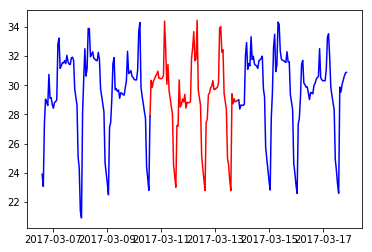

In [199]:
plt.plot(dftest_P_J422.loc['2017-03-10 14':'2017-03-13 21', 'P_J422'],color="red")

plt.plot(dftest_P_J422.loc['2017-03-06 14':'2017-03-10 14', 'P_J422'],color="blue")
plt.plot(dftest_P_J422.loc['2017-03-13 21':'2017-03-17 21', 'P_J422'],color="blue")

#### Attack 7

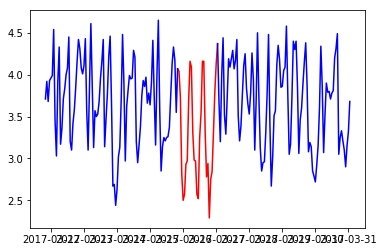

In [201]:
plt.plot(dftest_L_T4.loc['2017-03-25 20':'2017-03-27 01', 'L_T4'],color="red")

plt.plot(dftest_L_T4.loc['2017-03-21 20':'2017-03-25 20', 'L_T4'],color="blue")
plt.plot(dftest_L_T4.loc['2017-03-27 01':'2017-03-31 01', 'L_T4'],color="blue")

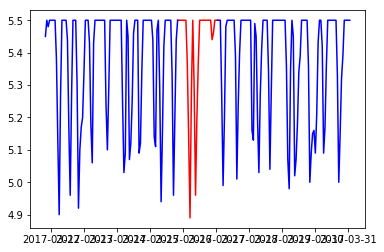

In [202]:
plt.plot(dftest_L_T6.loc['2017-03-25 20':'2017-03-27 01', 'L_T6'],color="red")

plt.plot(dftest_L_T6.loc['2017-03-21 20':'2017-03-25 20', 'L_T6'],color="blue")
plt.plot(dftest_L_T6.loc['2017-03-27 01':'2017-03-31 01', 'L_T6'],color="blue")

### Labling all the attacks in one dataset to compute performance

In [214]:
dftest[" ATT_FLAG"]=0
dftest.loc['2017-01-16 09':'2017-01-19 06',' ATT_FLAG']=1
dftest.loc['2017-01-30 08':'2017-02-02 00',' ATT_FLAG']=1
dftest.loc['2017-02-09 03':'2017-02-10 09',' ATT_FLAG']=1
dftest.loc['2017-02-12 01':'2017-02-13 07',' ATT_FLAG']=1
dftest.loc['2017-02-24 05':'2017-02-28 08',' ATT_FLAG']=1
dftest.loc['2017-03-10 14':'2017-03-13 21',' ATT_FLAG']=1
dftest.loc['2017-03-25 20':'2017-03-27 01',' ATT_FLAG']=1

### Scaling the data to normal distribution with mean zero and standard deviation one and plotting one column to validate the execution

In [7]:
# Getting one column to test the code
dataset=dftrain1['L_T7']

C:\Users\pvbia\Anaconda3\lib\site-packages\pandas\plotting\_converter.py:129: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


([], <a list of 0 Text xticklabel objects>)

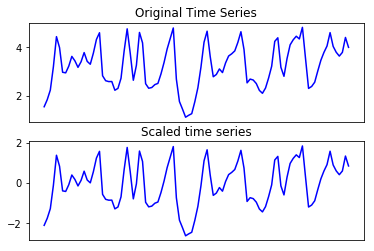

In [8]:
## Creating a function that scale and standardize a dataset
def scaling(mu,std,data):
    scaler = TimeSeriesScalerMeanVariance(mu=mu, std=std)
    return scaler.fit_transform(data)

## Running the function
dataset_scale=scaling(0,1,dataset)

## Plotting the first 100 observations to check if it worked

# Plotting the original time series
plt.figure()
plt.subplot(2, 1, 1)  # First, raw time series
plt.plot(dataset[0:100], "b-")
plt.title("Original Time Series")
plt.xticks([])

# Plotting the scaled time series
plt.subplot(2, 1, 2)  # Second, PAA
plt.plot(dataset_scale.ravel()[0:100], "b-")
plt.title("Scaled time series")
plt.xticks([])

## 2) Discretization 

Creating a Piecewise Aggregate Approximation (PAA) representation (not necessary for the sake of the code, we just used it to plot and compare with the SAX representation to validate the transformation)

In [9]:
### Firstly, creting a function that creates the PPA
def ppa(n_paa_segments,dataset_scale):
    # Number of PAA segments to compute - one segment for every 4 hours
    n_paa_segments=int(round([len(x) for x in dataset_scale][0]/4,0))
    # Creating a piecewise aggregation approximation using n_paa_segments
    paa = PiecewiseAggregateApproximation(n_segments=n_paa_segments)
    # Compute paa time series corresponding (by paa.inverse_trasnform) to the fitted PAA representation (done by fit_transform)
    return  paa.inverse_transform(paa.fit_transform(dataset_scale))

### Running the function to test it for a given column of the dataset
n_paa_segments=int(round(len(dftrain1)/4,0))
paa_dataset_inv=ppa(n_paa_segments,dataset_scale)

Creating the Symbolic Aggregate Approximation (SAX)

In [10]:
### Firstly, creting a function that creates the sax
def tosax(n_paa_segments,n_sax_symbols,dataset_scale):
    #Creating the SAX using 'n_paa_segments' as number of segments and 'n_sax_symbols' as number of symbols
    sax = SymbolicAggregateApproximation(n_segments=n_paa_segments, alphabet_size_avg=n_sax_symbols)
    # Compute sax time series corresponding (by sax.inverse_transform) to the fitted PAA representation (done by sax.fit_transform)
    return sax.inverse_transform(sax.fit_transform(dataset_scale))

### Running the function to test it for a given column of the dataset
n_sax_symbols = 5
sax_dataset_inv=tosax(n_paa_segments,n_sax_symbols,dataset_scale)

Plotting the scaled time series, PAA and SAX representations for the sake of validation of the code

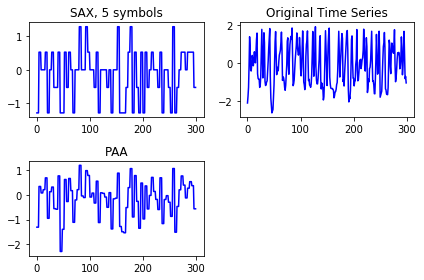

In [11]:
#Plotting - only 100 first values to test the code isworking as expected

# Plotting the scaled data set
plt.subplot(2, 2, 2)  # First, raw time series
plt.plot(dataset_scale.ravel()[0:300], "b-")
plt.title("Original Time Series")

#Plotting the PAA (ONLY FOR COMPARISON PURPOSES)
plt.subplot(2, 2, 3)  
plt.plot(paa_dataset_inv[0].ravel()[0:300], "b-")
plt.title("PAA")

#Plotting the SAX
plt.subplot(2, 2, 1)  # Then SAX
plt.plot(sax_dataset_inv[0].ravel()[0:300], "b-")
plt.title("SAX, %d symbols" % n_sax_symbols)

plt.tight_layout()
plt.show()

## 3) N-Grams Representations

Creating a function that returns its n-gram representation.

In [12]:
#'a' will be used just to test the functions below.
a=sax_dataset_inv[0].ravel()

We need function(s) to convert numeric values generated from the sax to a string to perform N-grams as a it was a NLP problem. For this purpose two functions were created: the first just put all the values of a list in a string and the second convert numerical values of the sax to letters

In [13]:
# First function convert a list of numeric values to a string
def convert(list): 
    # Converting integer list to string list 
    s = [str(i) for i in list] 
    # Join list items using join() 
    res = ("".join(s)) 
    return(res) 

In [14]:
# Second function to convert a sax numeric representation into strings
def saxtostring(sax):
    #Creating a list with all unique elements
    setsax=set(sax)
    L=[]
    for i in setsax:
        L.append(i)
    L=sorted(L)
    #Creating a dictinary with the elements that need to be converted
    D={}
    for i in range(0,len(L)):
        D[L[i]]=string.ascii_lowercase[i]
    #Converting the numerical values to strings
    output=[]
    for i in range(0,len(sax)):
        output.append(D[sax[i]])
    return output  
#To test
b=saxtostring(a)

Now to generate Ngrams we need a function that gather from the data the possible grams and their possible next values.

In [15]:
#Function that creates the Ngrams representation by creating a dictionary that has as keys the representations and as values
#the number elements generated after the n-gram
def tongrams(tokens,n):
    #Creates a dictionary with the Ngrams representation and the next element (that is to be predicted by the ngrams)
    D = {}
    #Loop needs to go up to len(tokens)-n-1 to not get out of bounds
    for i in range(0,len(tokens)-n-1):
        #If new key, we add this key to the dictionary
        if convert(tokens[i:(i+n)]) not in D.keys():
            D[convert(tokens[i:(i+n)])] = [convert(tokens[i+n+1])]
        #If existing key, append new value
        else:
            D[convert(tokens[i:(i+n)])].append(tokens[i+n+1])
    return D
#To test
g=tongrams(b,3)

Now we create a Markov Chain that calculates the prior and the posterior given the dictionary generated by the previous function.

In [16]:
#Function that calcualte the likelihood given a ngram
def tomarkovchain(ngram):
    #Create dictionary to be filled with the probability of conditional events (likelihood)
    l_probs=dict()
    #Create the dictionaries to be filled with the counting for each gram
    c1=dict()
    #Loop through keys to calculate the likelihood for each key
    for key in ngram.keys():
        #Create the variable to be filled with tally of the number of times that a value repeat for each key
        counts = dict()
        for i in ngram[key]:
            counts[i] = counts.get(i, 0) + 1
        #Create the dictionary to be filled with the probability of the conditional events (likelihood)
        l=dict()

        #Calculate the probability by dividing the count to the sum of values
        for j in counts.keys():
            l[j]=counts[j]/sum(counts.values())
    
        #Assign to each key the dictionary with the probabilities
        l_probs[key]=l
        #Assign to each key the dictionary with the counting
        c1[key]=counts
    

    # Return the likelihood,the prior and the counting
    return [l_probs,c1]

#To test
m=tomarkovchain(g)

In [17]:
#Smoothing the prior
#This function return the smoothed probability
def smooth_ngram_prob(markovchain_model,n_sax_symbols,input_gram,output_gram):
    
    #Calculating denominators
    ngrams_number=len(random.choice(list(markovchain_model[0].keys())))
    
    #Smoothing
    if input_gram in markovchain_model[1].keys():
        total_values_for_the_key=sum(markovchain_model[1][input_gram].values())
        #The Probability is calculated by adding 1 observation for all possible grams (total of n_sax_symbols**ngrams_number )
        smoothed=(markovchain_model[1][input_gram].get(output_gram,0)+1)/(total_values_for_the_key+n_sax_symbols)
    else:
        #There is no observation of this gram
        smoothed=0
        
    return smoothed

#To test
smooth_ngram_prob(m,5,"aae","a")


0.0625

Lastly, we create a function that loop through the dataframe and return the index that are below a certain threshold

In [18]:
def prediction(markovchain_model,n_sax_symbols,string_sax, threshold):
    #Calculating number of ngrams used
    n=len(random.choice(list(markovchain_model[0].keys())))
    #Calculationg the number of times a observation should be reproduced so the data set has the same size as the original

    #Creating the list to store the values
    L=[]
    #And a list to store the probabilities
    P=[]
    #looping
    for i in range(0,len(string_sax)):
        if (i<=(n+1)):
            L.append(0)
            P.append(0)
        else:
            P.append(smooth_ngram_prob(markovchain_model,n_sax_symbols,convert(string_sax[i:(i+n)]),string_sax[i]))
            if smooth_ngram_prob(markovchain_model,n_sax_symbols,convert(string_sax[i:(i+n)]),string_sax[i])<threshold:
                L.append(1)
            else:
                L.append(0)
    return [L,P]

pred_test=prediction(m,5,b, 0.05)[0]

And a function that merge the predictions into the original dataframe considering the possible rounding differences that may lead to difference in length when creating SAX

In [19]:
def smartmerge(df,predictions):
    df=pd.Series.to_frame(df)
    
    if len(predictions)==len(df):
        df.insert(1, "predictions", predictions)
        df.reset_index(inplace=True)
    
    if len(predictions)>len(df):
        predictions=predictions[:-(len(predictions)-len(df))]
        df.insert(1, "predictions", predictions)
        df.reset_index(inplace=True)
    
    if len(predictions)<len(df):
        for i in range(0,(len(df)-len(predictions))):
            predictions.append(0)
            df.insert(1, "predictions", predictions)
            
    #To help to plot latter
    #df['color'] = df['predictions'].apply(lambda x: "blue" if x==0 else "red")
        
    return df        

## 4) Predictions Attacks Using N-grams

_In this subchapter we are going to try to predict the attacks on the training dataset 2_

### Creating functions that aid the prediction

Creating a function that make predicitons and calculate performance indicators.

In [20]:
def model_to_predict(trainset,testset,results,n_sax_symbols,n_paa_segments,n_grams,threshold):
   
    ###Generating the model for the train set###
    #Scaling
    s_train=scaling(0,1,trainset)
    #Sax
    sax_train=tosax(n_paa_segments,n_sax_symbols,s_train).ravel()
    #Sax to string
    sax_string_train=saxtostring(sax_train)
    #Ngrams
    ngrams=tongrams(sax_string_train,n_grams)
    #Markov Chain
    m=tomarkovchain(ngrams)
    
    ###Preparing the test set###
    #Scaling
    s_test=scaling(0,1,testset)
    #Sax
    sax_test=tosax(n_paa_segments,n_sax_symbols,s_test).ravel()
    #Sax to string
    sax_string_test=saxtostring(sax_test)

    ###Making predictions
    pred=prediction(m,n_sax_symbols,sax_string_test, threshold)[0]
    predictions_df=smartmerge(testset,pred)
    
    ###Calculating the performance
    cm=confusion_matrix(list(results), list(predictions_df['predictions']))
    if cm.shape==(3,3):
        cm=cm[(0,2),1:]
    #True positive, false positive, false negative and true positive
    tn, fp, fn, tp = cm.ravel()
    #Getting the ratios
    recall=tp/(tp+fn)
    precision=tp/(tp+fp)
    accuracy=(tp+tn)/(tp+tn+fn+fp)
    f1=fbeta_score(list(results), list(predictions_df['predictions']),average='micro',beta=0.5)
    #Probability vector
    probab=prediction(m,n_sax_symbols,sax_string_test, threshold)[1]
    performance={"recall":recall,"precision":precision,"Accuracy":accuracy,"F1":f1}
    
    return [cm,performance,probab]

In [21]:
#Testing
sax=5
paa=336
n=10
t=0.05
MODEL=model_to_predict(dftrain1["L_T7"],dftrain2[" L_T7"],dftrain2[' ATT_FLAG'],sax,paa,n,t)

Creating a function that plot the confusion matrix

In [22]:
def ploting_cm(cm):
    
    #Plot
    ax= plt.subplot()
    sns.heatmap(cm, annot=True,fmt='g', ax = ax); #annot=True to annotate cells

    # labels, title and ticks
    ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
    ax.set_title('Confusion Matrix'); 
    ax.xaxis.set_ticklabels(['normal', 'anomaly']); ax.yaxis.set_ticklabels(['normal', 'anomaly'])

Creating a function that loop over the parameters and select based on that the best set of parameters

In [56]:
def parameterselection(trainset,testset,results):
    #Genereting one first model to have a starting value for the loop with (almost) selected parameters
    parameters={"sax":5,"paa":2,"ngram":6,"threshold":0.10}
    best_MODEL=model_to_predict(trainset,testset,results,7,int(len(dftrain1)/2),3,0.15)
    #Looping
    for sax in range(5,10,1):
        for paa in range(2,25,2):
            for n in range(1,48,2):
                for t in [0.01,0.05,0.1,0.2,0.3,0.4,0.5]:
                    MODEL=model_to_predict(trainset,testset,results,sax,int(len(dftrain1)/paa),n,t)
                    #Selecting using accuracy and recall
                    if (MODEL[1]["F1"]>best_MODEL[1]["F1"]) and (MODEL[1]["recall"]>0.05) and (MODEL[1]["precision"]>0.05):
                    #if (MODEL[1]["precision"]>0.1) and (MODEL[1]["recall"]>0.4):
                        best_MODEL=MODEL
                        parameters={"sax":sax,"paa":paa,"ngram":n,"threshold":t}

    return [best_MODEL,parameters]

### Predicting Attacks for some sensors in the train data set 2

The Loop below will select the best parameters for the model.

**It takes time(roughly 4 hours in my computer) to run , please be advised**

_The code will just select the best parameters based on the train set 2 - nothing else_

In [57]:
#############train
#L_T7
L_T7=parameterselection(dftrain1["L_T7"],dftrain2_L_T7[" L_T7"],dftrain2_L_T7[' ATT_FLAG'])

#F_PU10
F_PU10=parameterselection(dftrain1["F_PU10"],dftrain2_F_PU10[" F_PU10"],dftrain2_F_PU10[' ATT_FLAG'])

#F_PU11
F_PU11=parameterselection(dftrain1["F_PU11"],dftrain2_F_PU11[" F_PU11"],dftrain2_F_PU11[' ATT_FLAG'])

#L_T1
L_T1=parameterselection(dftrain1["L_T1"],dftrain2_L_T1[" L_T1"],dftrain2_L_T1[' ATT_FLAG'])

#F_PU1
F_PU1=parameterselection(dftrain1["F_PU1"],dftrain2_F_PU1[" F_PU1"],dftrain2_F_PU1[' ATT_FLAG'])

#F_PU2
F_PU2=parameterselection(dftrain1["F_PU2"],dftrain2_F_PU2[" F_PU2"],dftrain2_F_PU2[' ATT_FLAG'])

#L_T4
L_T4=parameterselection(dftrain1["L_T4"],dftrain2_L_T4[" L_T4"],dftrain2_L_T4[' ATT_FLAG'])

C:\Users\pvbia\Anaconda3\lib\site-packages\ipykernel_launcher.py:35: RuntimeWarning: invalid value encountered in longlong_scalars


KeyboardInterrupt: 

### Predicting Attacks for some sensors in the test data

According to the information provided about the BATADAL dataset, Anomalies can be found at 'L_T3', 'F_PU4', 'F_PU5', 'L_T2, 'V2', 'P_J14', 'P_J422, 'L_T7', 'F_PU10', 'F_PU11', 'L_T6'.

The parameters for prediction will be those optimized by on the traindataset 2. When not available the parameters will be for one close variable

In [ ]:
###Creating one dataset for each dimension
#Attack 1
dftest_L_T3=dftest.loc[:,['L_T3',' ATT_FLAG']]
dftest_P_U4=dftest.loc[:,['F_PU4', ' ATT_FLAG']]
dftest_P_U5=dftest.loc[:,['F_PU5', ' ATT_FLAG']]
#Attack 2
dftest_L_T2=dftest.loc[:,['L_T2', ' ATT_FLAG']]
#Attack 3
dftest_P_U3=dftest.loc[:,['F_PU3', ' ATT_FLAG']]
#Attack 4
dftest_P_U3=dftest.loc[:,['F_PU3', ' ATT_FLAG']]
#Attack 5
dftest_L_T2=dftest.loc[:,['L_T2', ' ATT_FLAG']]
dftest_V2=dftest.loc[:,['F_V2', ' ATT_FLAG']]
dftest_P_J14=dftest.loc[:,['P_J14', ' ATT_FLAG']]
dftest_P_J422=dftest.loc[:,['P_J422', ' ATT_FLAG']]
#Attack 6
dftest_L_T7=dftest.loc[:,['L_T7', ' ATT_FLAG']]
dftest_P_U10=dftest.loc[:,['F_PU10', ' ATT_FLAG']]
dftest_P_U11=dftest.loc[:,['F_PU11', ' ATT_FLAG']]
dftest_P_J14=dftest.loc[:,['P_J14', ' ATT_FLAG']]
dftest_P_J422=dftest.loc[:,['P_J422', ' ATT_FLAG']]
#Attack 7
dftest_L_T4=dftest.loc[:,['L_T4', ' ATT_FLAG']]
dftest_L_T6=dftest.loc[:,['L_T6', ' ATT_FLAG']] 

In [203]:
#'L_T3'
trainset=dftrain1['L_T3']
testset=dftest['L_T3']
sax=L_T7[1]["sax"]
paa=L_T7[1]["paa"]
n=L_T7[1]["ngram"]
t=L_T7[1]["threshold"]
results=dftest_L_T3[' ATT_FLAG']
MODEL_LT3=model_to_predict(trainset,testset,results,sax,int(len(dftrain1)/paa),n,t)
#'F_PU4'
trainset=dftrain1['F_PU4']
testset=dftest['F_PU4']
sax=F_PU10[1]["sax"]
paa=F_PU10[1]["paa"]
n=F_PU10[1]["ngram"]
t=F_PU10[1]["threshold"]
results=dftest_P_U4[' ATT_FLAG']
MODEL_F_PU4=model_to_predict(trainset,testset,results,sax,int(len(dftrain1)/paa),n,t)
#'F_PU5'
trainset=dftrain1['F_PU5']
testset=dftest['F_PU5']
sax=F_PU10[1]["sax"]
paa=F_PU10[1]["paa"]
n=F_PU10[1]["ngram"]
t=F_PU10[1]["threshold"]
results=dftest_P_U5[' ATT_FLAG']
MODEL_F_PU5=model_to_predict(trainset,testset,results,sax,int(len(dftrain1)/paa),n,t)
#'L_T2
trainset=dftrain1['L_T2']
testset=dftest['L_T2']
sax=L_T7[1]["sax"]
paa=L_T7[1]["paa"]
n=L_T7[1]["ngram"]
t=L_T7[1]["threshold"]
results=dftest_L_T2[' ATT_FLAG']
MODEL_L_T2=model_to_predict(trainset,testset,results,sax,int(len(dftrain1)/paa),n,t)
#'P_J14'
trainset=dftrain1['P_J14']
testset=dftest['P_J14']
sax=L_T7[1]["sax"]
paa=L_T7[1]["paa"]
n=L_T7[1]["ngram"]
t=L_T7[1]["threshold"]
results=dftest_P_J14[' ATT_FLAG']
MODEL_P_J14=model_to_predict(trainset,testset,results,sax,int(len(dftrain1)/paa),n,t)
#'P_J422
trainset=dftrain1['P_J422']
testset=dftest['P_J422']
sax=L_T7[1]["sax"]
paa=L_T7[1]["paa"]
n=L_T7[1]["ngram"]
t=L_T7[1]["threshold"]
results=dftest_P_J422[' ATT_FLAG']
MODEL_P_J422=model_to_predict(trainset,testset,results,sax,int(len(dftrain1)/paa),n,t)
#'L_T7'
trainset=dftrain1['L_T7']
testset=dftest['L_T7']
sax=L_T7[1]["sax"]
paa=L_T7[1]["paa"]
n=L_T7[1]["ngram"]
t=L_T7[1]["threshold"]
results=dftest_L_T7[' ATT_FLAG']
MODEL_L_T7=model_to_predict(trainset,testset,results,sax,int(len(dftrain1)/paa),n,t)
#'F_PU10'
trainset=dftrain1['F_PU10']
testset=dftest['F_PU10']
sax=F_PU10[1]["sax"]
paa=F_PU10[1]["paa"]
n=F_PU10[1]["ngram"]
t=F_PU10[1]["threshold"]
results=dftest_P_U10[' ATT_FLAG']
MODEL_F_PU10=model_to_predict(trainset,testset,results,sax,int(len(dftrain1)/paa),n,t)
#'F_PU11'
trainset=dftrain1['F_PU11']
testset=dftest['F_PU11']
sax=F_PU11[1]["sax"]
paa=F_PU11[1]["paa"]
n=F_PU11[1]["ngram"]
t=F_PU11[1]["threshold"]
results=dftest_P_U11[' ATT_FLAG']
MODEL_F_PU11=model_to_predict(trainset,testset,results,sax,int(len(dftrain1)/paa),n,t)
#'L_T6'
trainset=dftrain1['L_T6']
testset=dftest['L_T6']
sax=L_T7[1]["sax"]
paa=L_T7[1]["paa"]
n=L_T7[1]["ngram"]
t=L_T7[1]["threshold"]
results=dftest_L_T6[' ATT_FLAG']
MODEL_L_T6=model_to_predict(trainset,testset,results,sax,int(len(dftrain1)/paa),n,t)

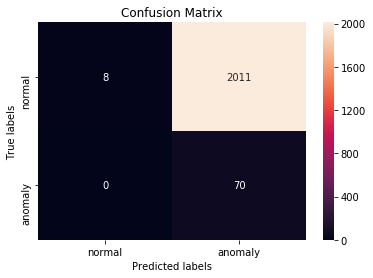

In [204]:
#'L_T3'
ploting_cm(MODEL_LT3[0])

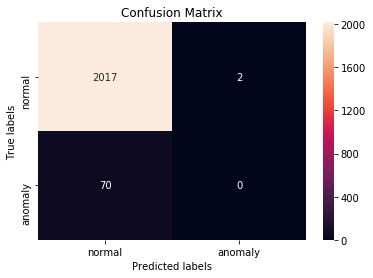

In [205]:
#'F_PU4'
ploting_cm(MODEL_F_PU4[0])

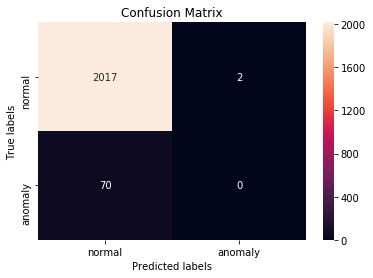

In [206]:
#'F_PU5'
ploting_cm(MODEL_F_PU5[0])

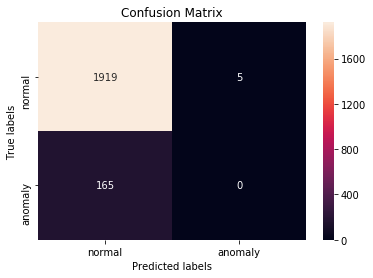

In [207]:
#'L_T2
ploting_cm(MODEL_L_T2[0])

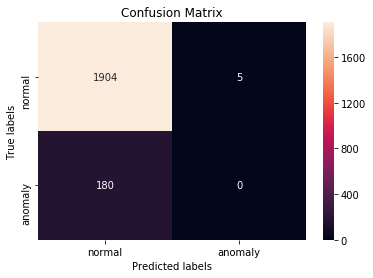

In [208]:
#'P_J14'
ploting_cm(MODEL_P_J14[0])

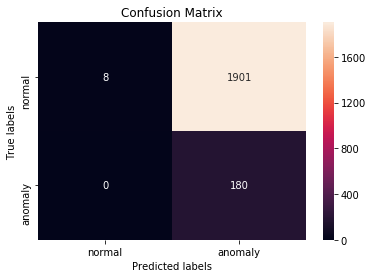

In [209]:
#'P_J422
ploting_cm(MODEL_P_J422[0])

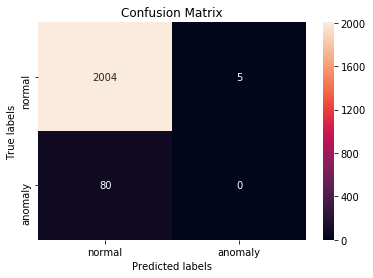

In [210]:
#'L_T7'
ploting_cm(MODEL_L_T7[0])

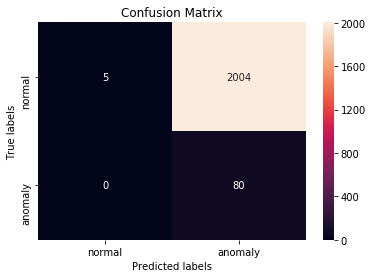

In [211]:
#'F_PU10'
ploting_cm(MODEL_F_PU10[0])

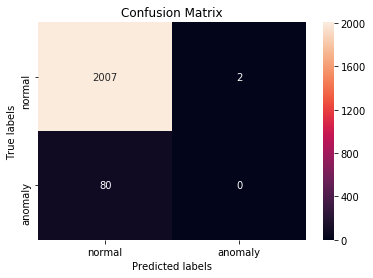

In [212]:
#'F_PU11'
ploting_cm(MODEL_F_PU11[0])

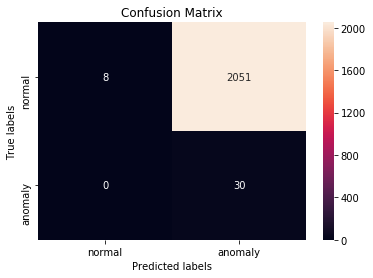

In [213]:
#'L_T6'
ploting_cm(MODEL_L_T6[0])